In [8]:
#tipos de casas:
#castelo - castle
#iglu - igloo
#cabana - hut


obs: adicionei as coisas do quinto capítulo, mas não sei se piorou ou melhorou. mas pelo menos está funcionando. 

In [9]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [10]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [11]:
key = os.environ.get('AZURE_SEARCH_KEY', 'e6c303f4168e494b81536613658455fc')

In [12]:
results = search_images_bing(key, 'castle')
imsCastle = results.attrgot('content_url')
len(imsCastle)

150

In [13]:
ims = ['https://th.bing.com/th/id/OIP.I7TADkd5wEI1vTOLuZe0qQHaEo?pid=ImgDet&rs=1']

In [15]:
houses_types = 'castle','igloo','hut'
path = Path('houses')

In [16]:
if not path.exists():
    path.mkdir()
    for o in houses_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o}')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [17]:
fns = get_image_files(path)
fns

(#425) [Path('houses/igloo/00000055.jpeg'),Path('houses/igloo/00000025.jpg'),Path('houses/igloo/00000144.jpg'),Path('houses/igloo/00000084.jpg'),Path('houses/igloo/00000040.jpg'),Path('houses/igloo/00000056.jpg'),Path('houses/igloo/00000036.jpg'),Path('houses/igloo/00000121.jpg'),Path('houses/igloo/00000002.jpg'),Path('houses/igloo/00000009.jpg')...]

In [18]:
failed = verify_images(fns)
failed

(#9) [Path('houses/igloo/00000106.jpg'),Path('houses/igloo/00000135.jpg'),Path('houses/hut/00000048.jpg'),Path('houses/hut/00000113.jpg'),Path('houses/castle/00000040.jpg'),Path('houses/castle/00000082.jpg'),Path('houses/castle/00000097.jpg'),Path('houses/castle/00000111.jpg'),Path('houses/castle/00000064.jpg')]

In [19]:
failed.map(Path.unlink);

In [20]:
houses = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [21]:
dls = houses.dataloaders(path)


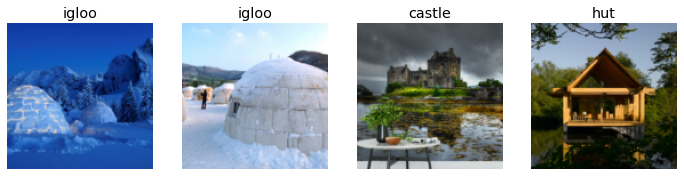

In [22]:
dls.valid.show_batch(max_n=4, nrows=1)

In [23]:
#não sei se os códigos dos blocos abaixo são necessários pro treinamento do modelo ou se servem apenas pra visualizar. na dúvida, coloquei.

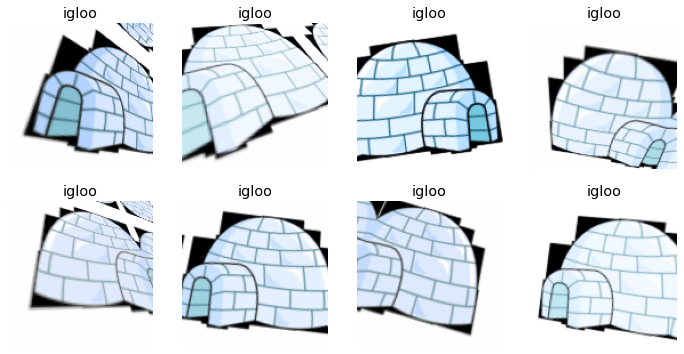

In [24]:
houses = houses.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = houses.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [25]:
houses = houses.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = houses.dataloaders(path)

In [26]:

learn = cnn_learner(dls, resnet34, metrics=error_rate) 
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.482591,0.154094,0.060241,00:16


epoch,train_loss,valid_loss,error_rate,time
0,0.399573,0.084394,0.036145,00:16
1,0.234840,0.069754,0.036145,00:16
2,0.164763,0.059321,0.036145,00:17
3,0.123005,0.056905,0.036145,00:17


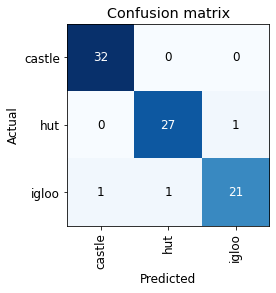

In [27]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

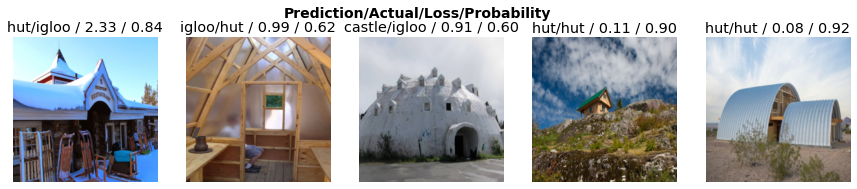

In [28]:
interp.plot_top_losses(5, nrows=1)

In [29]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [30]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

------------- cap 5 ------------------

In [31]:
learn.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,0.199929,1.264551,0.072289,00:19


epoch,train_loss,valid_loss,error_rate,time
0,2.662358,50524.269531,0.722892,00:17


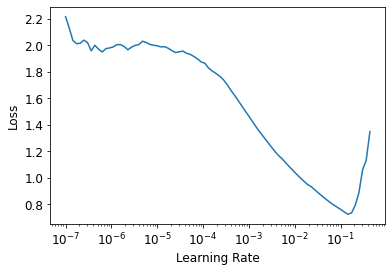

In [32]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find()

In [33]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.45e-02, steepest point: 3.31e-04


In [34]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=2e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.393546,0.107355,0.036145,00:16


epoch,train_loss,valid_loss,error_rate,time
0,0.293631,0.048019,0.024096,00:17
1,0.193158,0.032448,0.012048,00:16


In [35]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 2e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.460541,0.178069,0.084337,00:16
1,0.774078,0.116399,0.036145,00:17
2,0.540876,0.124114,0.036145,00:16


In [36]:
learn.unfreeze()

SuggestedLRs(lr_min=0.00014454397605732084, lr_steep=1.5848931980144698e-06)

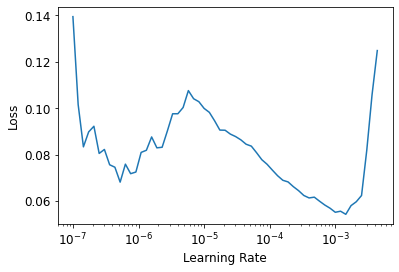

In [37]:
learn.lr_find()

In [60]:
learn.fit_one_cycle(3, lr_max=1e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.052915,0.069304,0.036145,00:16
1,0.027675,0.057197,0.024096,00:16
2,0.022048,0.063800,0.036145,00:16


In [61]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(1, 2e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.132678,0.218350,0.120482,00:16


epoch,train_loss,valid_loss,error_rate,time
0,0.179477,0.090350,0.036145,00:15
1,0.208235,0.072452,0.024096,00:17
2,0.197686,0.068025,0.024096,00:16
3,0.175117,0.066819,0.024096,00:16
4,0.172091,0.068916,0.024096,00:16
5,0.157859,0.070992,0.024096,00:17
6,0.146559,0.070252,0.024096,00:16
7,0.134024,0.067826,0.024096,00:17
8,0.121069,0.066434,0.024096,00:16
9,0.112587,0.065474,0.024096,00:17


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f60e7c8d9e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f60e7c8d9e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

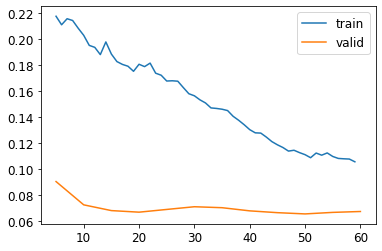

In [62]:
learn.recorder.plot_loss()

-------------------------- cap 5 -----------------------

In [63]:
learn.export()

In [64]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [65]:
learn_inf = load_learner(path/'export.pkl')

In [66]:
learn_inf.predict('houses/castle/00000000.jpg')

('castle', tensor(0), tensor([9.9996e-01, 8.3195e-06, 2.8943e-05]))

In [67]:
learn_inf.dls.vocab

['castle', 'hut', 'igloo']

In [68]:
btn_upload = widgets.FileUpload()
##btn_upload

In [ ]:
##img = PILImage.create(btn_upload.data[-1])

In [69]:
out_pl = widgets.Output()
out_pl.clear_output()
##with out_pl: display(img.to_thumb(128,128))
##out_pl

In [70]:
##pred,pred_idx,probs = learn_inf.predict(img)

In [71]:
lbl_pred = widgets.Label()
##lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
##lbl_pred

In [72]:
btn_run = widgets.Button(description='Classify')
##btn_run

In [73]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [74]:
btn_upload = widgets.FileUpload()

In [75]:
VBox([widgets.Label('Select your house!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

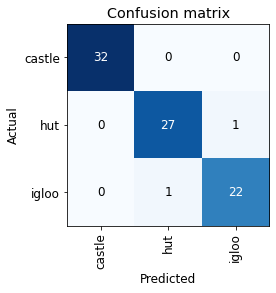

In [76]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [77]:
#isso tem no livro (transformar o notebook em um app) -> teriamos que fazer?
#hide
!pip install voila
!jupyter serverextension enable --sys-prefix voila 

     |████████████████████████████████| 1.6MB 17.9MB/s 
     |████████████████████████████████| 122kB 33.8MB/s 
     |████████████████████████████████| 552kB 56.3MB/s 
     |████████████████████████████████| 378kB 45.8MB/s 
     |████████████████████████████████| 71kB 8.8MB/s 
ERROR: nbdev 1.1.14 has requirement nbconvert<6, but you'll have nbconvert 6.0.7 which is incompatible.
ERROR: jupyter-server 1.6.4 has requirement tornado>=6.1.0, but you'll have tornado 5.1.1 which is incompatible.
  Found existing installation: jupyter-client 5.3.5
    Uninstalling jupyter-client-5.3.5:
      Successfully uninstalled jupyter-client-5.3.5
  Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1


Enabling: voila
- Writing config: /usr/etc/jupyter
    - Validating...
Error loading server extension voila
      X is voila importable?
